In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
depth = 9
d = 40

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    add_layerRZ(data)

In [5]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [6]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [7]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [8]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [9]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [12]:
fubini_matrices = []
eigen_vals = []
paramsV = []
dataV = []

In [13]:
start_qfi = time.time()

for i in range(500):
    print(i)
    np.random.seed(i)
    data = np.random.uniform(-1,1,numQubits) 
    print(data)
    dataV.append(data)
    params = np.random.uniform(-1,1,d)
    print(params)
    paramsV.append(params)
    fubini = fubini_calculate(data, params, depth)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

0
[0.09762701 0.43037873 0.20552675 0.08976637]
[-0.1526904   0.29178823 -0.12482558  0.783546    0.92732552 -0.23311696
  0.58345008  0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414
 -0.95956321  0.66523969  0.5563135   0.7400243   0.95723668  0.59831713
 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343  0.88933783
  0.04369664 -0.17067612 -0.47088878  0.54846738 -0.08769934  0.1368679
 -0.9624204   0.23527099  0.22419145  0.23386799  0.88749616  0.3636406
 -0.2809842  -0.12593609  0.39526239 -0.87954906]
1
[-0.16595599  0.44064899 -0.99977125 -0.39533485]
[-0.70648822 -0.81532281 -0.62747958 -0.30887855 -0.20646505  0.07763347
 -0.16161097  0.370439   -0.5910955   0.75623487 -0.94522481  0.34093502
 -0.1653904   0.11737966 -0.71922612 -0.60379702  0.60148914  0.93652315
 -0.37315164  0.38464523  0.7527783   0.78921333 -0.82991158 -0.92189043
 -0.66033916  0.75628501 -0.80330633 -0.15778475  0.91577906  0.06633057
  0.38375423 -0.36896874  0.37300186  0.66925134 -

15
[ 0.69763539 -0.64220815 -0.89127357 -0.27692311]
[-0.44919814  0.06000045 -0.38816217 -0.39105128 -0.77651745 -0.50020197
  0.8352598  -0.47170629  0.43554737  0.73143007  0.61415896 -0.57889883
 -0.66551394 -0.90658722 -0.92115538 -0.59953838  0.99708681 -0.25442604
  0.52102055 -0.05305111  0.01943061  0.89007683 -0.7811067  -0.06981368
 -0.71688948  0.07669752 -0.40200269  0.07549044  0.33125508 -0.2713424
  0.24603724  0.28544977 -0.16003636 -0.19351513 -0.21915935 -0.18762096
 -0.84066779 -0.8863376  -0.84333818  0.39135562]
16
[-0.55341784  0.04632668  0.10140291 -0.9087961 ]
[-0.27854233 -0.55383812  0.37745232 -0.67253715 -0.85935027  0.88202172
  0.12736276 -0.84401532  0.44528102 -0.68309565 -0.49943739 -0.41302549
  0.39322143 -0.07147182 -0.56987571 -0.10634748 -0.7582425   0.83537402
  0.13289266 -0.05596137 -0.37086715 -0.91356854  0.50488983  0.08653809
  0.53438085  0.58089753 -0.85555724  0.31943167 -0.89340132  0.37004891
 -0.11329808 -0.06400771  0.32211867  0.37

30
[ 0.28828707 -0.23850302  0.32609581 -0.67269855]
[ 0.92521563 -0.30667632  0.98350198 -0.52988421  0.17138854 -0.1866198
 -0.72753136  0.08827258  0.03635269  0.53371021  0.86770029 -0.82059323
 -0.60845749  0.98838737 -0.529639   -0.52202726  0.25819966  0.46990515
  0.37668877 -0.9377385   0.80502769 -0.42712934  0.11122513 -0.24715951
 -0.94675127 -0.01170176  0.66943019 -0.26602534  0.03076422 -0.05524175
 -0.22769582  0.48827401 -0.32951584  0.19087658 -0.36773324 -0.30749915
 -0.51033638  0.39590033 -0.57583834 -0.46541366]
31
[-0.42789236  0.91621113  0.54062586  0.97374001]
[-0.58366908 -0.7261659   0.8167476  -0.86272296 -0.84933456  0.08706938
 -0.82120057 -0.23521346  0.33712088 -0.14166195 -0.91208739 -0.61142802
 -0.10668103 -0.87485344 -0.40486544  0.8872618  -0.43437785 -0.46461291
 -0.18556199  0.65198081  0.01340133 -0.46104924 -0.31962343  0.9489437
 -0.63139084 -0.51545565  0.38091863 -0.23212945 -0.07711509  0.35044997
 -0.82853879 -0.53196671  0.04491776 -0.861

45
[ 0.97802303  0.09908945 -0.4371054  -0.84542087]
[-0.11106101 -0.05438406 -0.902956   -0.6733511  -0.76809858  0.25478337
  0.7123641   0.30020484  0.98144337 -0.0592985   0.23658897 -0.43466559
  0.95200663  0.346136   -0.11893822 -0.42062532  0.01939937 -0.77507821
 -0.54609042 -0.04289539 -0.51448369 -0.22403496  0.63774686 -0.85091843
  0.84629908 -0.55020784  0.41274297 -0.77886909  0.20200825 -0.18641492
  0.6736589  -0.49993914 -0.08452402  0.11486541 -0.4960996  -0.77951736
  0.45327439 -0.37985212  0.65150793 -0.09666695]
46
[ 0.5676647   0.26966741 -0.50191382  0.51615173]
[-0.37384613  0.87447471 -0.9142691  -0.11826559  0.82544458 -0.08999216
  0.01586868 -0.83018409 -0.14730042  0.49143392  0.73416279 -0.35266835
 -0.79185121  0.60421609 -0.2103361   0.25553618 -0.92802291 -0.4001843
 -0.90469356 -0.25557784 -0.47516961  0.98105241 -0.2097093  -0.38492147
 -0.55779773 -0.01194995 -0.88424962 -0.42059992 -0.53009922  0.92686083
  0.23134775  0.72516794 -0.81982949 -0.70

61
[ 0.64893895 -0.63730054  0.75465354 -0.00089739]
[ 0.92985287 -0.99290891  0.84728869  0.25888783 -0.39140489 -0.31814984
 -0.71852964 -0.02599645  0.76209344 -0.09400993 -0.05000364  0.76468106
  0.33492749 -0.83634248 -0.94435315  0.44006692  0.423644   -0.92025365
 -0.06798271 -0.26521018  0.19844596  0.44937335 -0.61602533  0.05643785
 -0.4171138  -0.72101761  0.91196288  0.21008819  0.82056437 -0.08433673
 -0.9130343  -0.74687493 -0.33086149 -0.10428844 -0.14805435  0.09793139
  0.5393828   0.84439854  0.49938061 -0.41530546]
62
[-0.93249058 -0.02178498  0.69217019 -0.177196  ]
[ 0.26283075 -0.41811353  0.08560058 -0.54363724 -0.51944734  0.90691505
  0.29162086 -0.96428569  0.99225164  0.47038907  0.44388492 -0.17900698
 -0.59243961  0.92420506 -0.55105794 -0.90443447  0.76769434  0.77826413
  0.9255638   0.22234928  0.97162775 -0.19382021 -0.68616817  0.17489826
 -0.23095375 -0.41219154 -0.96484658 -0.06627979  0.82013286 -0.79496017
 -0.14277285 -0.73826715 -0.77597977  0.8

76
[-0.3783404   0.63797444 -0.33049475 -0.61257296]
[-0.77937335  0.92462017  0.7300945   0.70482395 -0.84097794  0.52147778
  0.72038655 -0.66929755  0.31261172 -0.26108856  0.63487744  0.83750116
 -0.67355958  0.66424701 -0.11432438  0.97531582  0.4784479   0.12515805
  0.55960501 -0.01154708  0.80449591  0.34529613  0.73665466  0.63139069
  0.8203448  -0.08622396 -0.43268322  0.81956553 -0.77532442 -0.84396244
  0.43328039  0.04454709  0.93689835  0.99663458  0.75945843  0.79774384
 -0.83856993  0.08152135 -0.92434962  0.36586017]
77
[ 0.83821806  0.2843912   0.50742446 -0.72137086]
[-0.8253609   0.57600412 -0.34769813  0.08213564 -0.51952965  0.09084585
 -0.19889099  0.43038377  0.67335988  0.17696229 -0.40769087 -0.43796462
  0.41119449 -0.15480714 -0.88536803  0.49405461 -0.09537397 -0.64845052
 -0.901246   -0.41504932 -0.86640174  0.50231297 -0.87245695 -0.13618336
 -0.27165517 -0.69605695  0.09342068 -0.11341392 -0.92787738  0.64578638
 -0.45341463 -0.66202956  0.28873951 -0.7

91
[-0.59799281 -0.34195907 -0.40700062 -0.81333266]
[-0.33384238  0.45044548  0.30472549  0.00970019  0.89466137  0.25480316
  0.98457268 -0.84775751 -0.31478295 -0.38612897  0.42040927  0.83463509
 -0.8381866  -0.87433354  0.1643366   0.33839645 -0.98131723 -0.15614682
 -0.20921714 -0.85359188  0.54059654 -0.62128149 -0.06398449  0.30349706
 -0.98367946 -0.86404998  0.49386035 -0.68505957  0.06960703  0.35255273
  0.03911055  0.0388006  -0.0684769  -0.51070398  0.82307994 -0.78465152
 -0.03648236  0.49741909 -0.23001678  0.50388161]
92
[ 0.771761    0.57716313 -0.15054374 -0.04226071]
[-0.99929188  0.71273409 -0.29335661 -0.02650191 -0.11745379  0.87716109
  0.43535777  0.68069833 -0.41696322  0.67047084 -0.10512586 -0.42143949
 -0.1932379   0.59857764  0.71167294  0.43211468  0.56689947  0.74026458
 -0.65807669 -0.11922257  0.54680043  0.84023426 -0.29490867 -0.7618991
 -0.25304969 -0.63506669 -0.98441958  0.83352889  0.50497883 -0.78466794
  0.35292295  0.07786366  0.0498289   0.22

107
[-0.67459008  0.50956176  0.1268037  -0.54947117]
[-0.31747643 -0.69501755 -0.30961757 -0.91665023 -0.50411925  0.19954562
  0.94194286  0.40412787  0.43989786 -0.60476361 -0.00839691 -0.58121518
  0.57935579  0.6367772  -0.73498868  0.85189724 -0.82105621  0.09863601
 -0.83663206 -0.07901337 -0.22997164 -0.02266559 -0.05215825 -0.48405641
  0.99170693 -0.23100935 -0.13889313  0.83297425  0.86635826  0.93069669
  0.05049889  0.79589351  0.06128008  0.20508366  0.42188926  0.97394597
 -0.34534802  0.37505989  0.87154227 -0.90594066]
108
[-0.53277773 -0.93122476  0.16017788 -0.74177143]
[ 0.37248292  0.36734988  0.74639194 -0.74607019  0.17933719 -0.89489555
 -0.35542726 -0.08852824  0.80995367  0.08266563 -0.92610077  0.39449993
  0.98785073 -0.60014189  0.28313056  0.4826419  -0.42413199 -0.80634121
  0.32592791 -0.71716944  0.28772011 -0.60393799  0.26101015  0.31007698
  0.4335846   0.05308719 -0.98454934 -0.91732384 -0.44518066  0.84874387
 -0.39079692  0.8749036   0.77094486 -0

122
[-0.68601632  0.40442008 -0.47704347 -0.09657418]
[-0.18386947  0.22308242  0.16616121 -0.57098226 -0.6224538   0.40419595
 -0.05836466 -0.02989426 -0.79769122 -0.27962777 -0.94421779 -0.52514692
  0.11778114 -0.59356437  0.13667066  0.69365744  0.68175682 -0.12398935
  0.39412106  0.81895044 -0.34060785 -0.62886275 -0.53394555  0.66701413
 -0.97883786 -0.48793875 -0.65839176 -0.96917142 -0.46877581  0.65456629
  0.66915912  0.73750275  0.9866298  -0.89990497 -0.78192099 -0.96776602
  0.76735289 -0.59828188 -0.12803232  0.21914401]
123
[ 0.39293837 -0.42772133 -0.54629709  0.10262954]
[ 0.43893794 -0.15378708  0.9615284   0.36965948 -0.0381362  -0.21576496
 -0.31364397  0.45809941 -0.12285551 -0.88064421 -0.20391149  0.47599081
 -0.63501654 -0.64909649  0.06310275  0.06365517  0.26880192  0.69886359
  0.44891065  0.22204702  0.44488677 -0.35408217 -0.27642269 -0.54347354
 -0.41257191  0.26195225 -0.81579012 -0.13259765 -0.13827447 -0.0126298
 -0.14833942 -0.37547755 -0.14729739  0.

138
[ 0.49868452  0.41046022 -0.35194494  0.90447688]
[ 0.68020165 -0.84483097 -0.23087182 -0.60975108  0.84591799  0.0526019
 -0.23632282 -0.88692065  0.80302571 -0.85489786 -0.55344198 -0.4560774
  0.9267764   0.76924799  0.31939326  0.8793431  -0.86491535  0.73500556
 -0.75392371 -0.54338403 -0.95058186 -0.93157022 -0.68274129 -0.55759068
  0.44438472  0.7166819  -0.79385225  0.27398491 -0.05661808 -0.17718968
  0.1385487   0.38124499 -0.54333822 -0.20358756  0.25732572 -0.01133269
 -0.68302241 -0.44898841 -0.71721229  0.58879852]
139
[-0.01807522  0.50648968  0.86844668  0.91792247]
[-0.68365407 -0.66803616 -0.4166387  -0.49947562 -0.58867586 -0.77078843
 -0.84314511 -0.17763221  0.10056573 -0.63587164 -0.99561183 -0.66141013
 -0.70628733  0.88770308  0.16684575 -0.16413271  0.94309318 -0.32914037
  0.0200636  -0.12585123  0.04344295  0.66705256 -0.15683215 -0.82136711
  0.17598431 -0.68424649 -0.39050948  0.13542167  0.41552382  0.7414532
  0.86038573 -0.6185846   0.8775803   0.14

153
[-0.70460029  0.0583688  -0.01266076 -0.88913621]
[-0.00743498  0.61504765 -0.55865833 -0.00872943  0.04129438 -0.43816771
  0.52967861  0.26654333  0.55021235 -0.18309114  0.35340004  0.10928879
 -0.62122421 -0.67431886  0.15752966 -0.64841443  0.83068335 -0.93472838
  0.16761     0.50837007  0.08689775 -0.03536177 -0.85107412 -0.01605365
 -0.54516171 -0.34454942  0.46741565  0.92662834 -0.56070573 -0.56923347
  0.85583706 -0.00976177  0.29361187 -0.71425251 -0.81722159  0.02303814
 -0.85580989  0.53900386  0.74136908 -0.82309488]
154
[0.01544754 0.26110121 0.37113112 0.97098661]
[ 0.73309611  0.6567369   0.43333491  0.19508043  0.70287373  0.20450107
 -0.71966539  0.6528342  -0.16500561  0.06551067  0.37612137  0.75584247
  0.60226169 -0.47986906 -0.72117895  0.97941266  0.48795207  0.35336497
  0.37988139 -0.72505223  0.79447683 -0.7489114   0.15061569 -0.83006297
  0.78186904 -0.46752558 -0.29439102 -0.92726788  0.29380165  0.49534027
  0.45664108  0.61036526 -0.54994216  0.126

168
[ 0.1955975   0.04169239 -0.50633458 -0.32500732]
[ 0.69289094  0.3028611   0.46680455  0.02356205  0.80852633  0.97255193
  0.55963879  0.83698482 -0.1965853   0.50411813  0.11518255 -0.0746038
  0.88939415  0.88639891  0.59488089 -0.11816428 -0.55939965 -0.27619788
 -0.08906041 -0.66542422  0.84785302 -0.51209683  0.6817239  -0.66521909
  0.34928944 -0.3499025  -0.02162968 -0.53410803  0.00235948 -0.9616234
 -0.92207957 -0.72381102 -0.07657646 -0.23727958  0.27958036 -0.17247412
 -0.26781391  0.34008765 -0.46833679  0.70422804]
169
[ 0.33918156  0.8151493   0.33585476 -0.84320484]
[-0.04897609  0.87037679 -0.69739403 -0.94794511 -0.61640518 -0.8173976
 -0.20911349  0.4347684  -0.14852568 -0.05751616 -0.65370862  0.18962084
 -0.96418934  0.66340325 -0.55348891 -0.5164509   0.60424767 -0.89496715
 -0.12814661 -0.61885673 -0.55249831  0.73837023  0.86420261 -0.22515634
  0.59468497 -0.53980049  0.8366267  -0.32163388 -0.96536116 -0.21959567
 -0.15195003 -0.64331531 -0.33531493  0.81

184
[-0.86308793  0.01056373  0.94460895 -0.60608373]
[-0.23496048 -0.88221978  0.12775211  0.13800086  0.62289427 -0.29234221
 -0.05930439 -0.38363974 -0.55625473  0.55820107  0.58912055  0.4573118
  0.88475974  0.47641852 -0.63453482 -0.14848702  0.96614069  0.22366545
  0.63386294  0.74805174  0.1760083  -0.03598982 -0.62676678  0.21638927
  0.57393562 -0.83661274  0.57395015 -0.4294393  -0.99242559  0.24989766
  0.41804356  0.82922846  0.36425011 -0.11729416  0.35659479  0.69774175
  0.36873502 -0.06766527  0.68501891  0.53020333]
185
[-0.7388929   0.0300949  -0.21139264  0.30855265]
[-0.42837394 -0.56073352  0.31362645  0.7799238   0.57488662  0.38531396
 -0.66308783 -0.2574419   0.77309693  0.4445204  -0.26592176  0.60594821
  0.47125335 -0.9555205  -0.29785472 -0.36083602  0.55582741  0.88366682
 -0.95151285 -0.83641011 -0.30292222 -0.3197631   0.80794465  0.835646
 -0.80635397  0.85588969 -0.63966764 -0.10226784 -0.5978809  -0.24140267
  0.68317747  0.28144827  0.21143893 -0.71

199
[ 0.30958339  0.96407857 -0.2001906   0.6883052 ]
[-0.0723153   0.08968613  0.23895568 -0.33632642  0.96199083 -0.47797756
  0.88001495 -0.91004683 -0.15968192  0.65997057  0.16142626 -0.7681906
 -0.78303474  0.78340009 -0.11138542  0.0782416   0.17766917  0.07869048
 -0.84001159 -0.28667255 -0.37793321  0.71488869  0.65443319 -0.00631342
  0.60540111 -0.03888045 -0.60990233  0.69055355 -0.38622605 -0.46130824
  0.70176815 -0.07148713  0.16127757  0.93163162 -0.4284818   0.74026291
 -0.83246804  0.57096949 -0.53928132 -0.78471187]
200
[ 0.89526451 -0.54690516  0.18884029 -0.14338263]
[ 0.52828137 -0.99427882 -0.28515264  0.81938977 -0.08783803  0.96360542
  0.73471398  0.97205502  0.84653341 -0.39261337  0.69220698 -0.75755606
  0.57115257 -0.49898989 -0.80794058  0.88698207  0.65210029  0.03665027
  0.74700084  0.15675138 -0.09983099  0.36031396 -0.16114876  0.28078693
  0.21731258 -0.78913179  0.93208918  0.51740083  0.35928367 -0.34130379
 -0.94709023  0.60732077  0.94565838 -0.

215
[-0.69215682 -0.02086975 -0.63602222 -0.58182122]
[-0.55366565 -0.83154613  0.83187863  0.21540153 -0.38297078  0.49193105
  0.62066647 -0.21477765 -0.17114039 -0.65850603  0.53597081 -0.19764579
 -0.27553781 -0.19973048 -0.42591928 -0.98021741 -0.33671983 -0.5516465
 -0.06535326  0.12826109  0.71280655  0.78316461 -0.04193059 -0.60614792
 -0.48890141  0.99027947 -0.16588814 -0.31648576  0.97231837  0.27014903
  0.63992949  0.46370791 -0.81280948  0.30912868  0.45339469 -0.07244566
  0.41893213 -0.66304411 -0.303908   -0.80631563]
216
[-0.92882193  0.55928935  0.37128209 -0.57763576]
[-0.51667623  0.88893863 -0.17037273  0.49067479 -0.73151399 -0.15292506
 -0.1061918   0.7415848   0.02188015 -0.31632598 -0.40689429  0.60119089
  0.34059408 -0.79215783 -0.03949161  0.49924893  0.40236514  0.13748288
  0.41165796  0.22415115  0.93137666 -0.09450992  0.9571448   0.35582095
  0.99927254  0.19612423 -0.60205378 -0.80678736 -0.55024849  0.22323926
  0.2552582  -0.47809346  0.43122508 -0.

231
[ 0.56298808  0.16841823 -0.14657986 -0.36931061]
[ 0.65377658  0.80685895 -0.92212379  0.83044519 -0.87898919 -0.63854628
 -0.85540056 -0.08247573  0.41671814 -0.03352985 -0.94910694 -0.86619513
 -0.14824398 -0.56150493  0.62026564 -0.71989205  0.50239881 -0.44179363
  0.89821103  0.77004272  0.22032452  0.5582382  -0.91688783  0.57282551
  0.80495303 -0.13401827  0.77316747  0.09708277  0.97395312  0.13061813
  0.80207136  0.12747593 -0.80820514  0.2350423  -0.87997071  0.16078873
  0.74336031  0.59968076 -0.86669334 -0.8796994 ]
232
[-0.34580735 -0.30772256 -0.71038851  0.30468038]
[-3.78823898e-01 -4.31807406e-01  6.95725918e-01  1.25584677e-01
 -8.49466539e-01  1.46750654e-01  3.93202586e-01 -6.18241556e-01
 -5.66457016e-01 -8.30669166e-01  2.06699891e-01  7.92708789e-02
 -1.47788367e-01 -5.77083615e-01  8.96557453e-01  4.07316861e-01
  7.81163839e-01 -8.54234064e-03 -4.58336780e-01  3.01922522e-01
  3.24731421e-02  1.02625043e-01 -1.71687076e-01 -9.08067093e-01
 -9.88342121e-

246
[-0.04070142  0.82493288  0.38083564  0.17876175]
[-0.98608622 -0.17890114  0.15088098 -0.07327949 -0.87181891 -0.3720273
 -0.07746398  0.9345591  -0.2951808   0.50632532  0.15504047  0.11958483
 -0.78155331  0.75247572 -0.4180593   0.99669673  0.83316772 -0.04673495
  0.1541685   0.2841726  -0.74935547 -0.08418677  0.43191025  0.87582919
 -0.3620195   0.84734876 -0.93157463 -0.68214093  0.41669223 -0.44561679
 -0.14633577  0.48136108 -0.82234533 -0.61577582  0.60601319 -0.76318425
  0.17230659 -0.93271126  0.47564872  0.37460186]
247
[-0.26763935  0.815083    0.66212101 -0.82818029]
[ 0.25269443 -0.23531351  0.71248692  0.10366079  0.54917454 -0.28591705
 -0.37993411 -0.59799988 -0.31159063 -0.07793128  0.77276416 -0.27649197
  0.05012631  0.9949739  -0.85940228 -0.08266005 -0.68318238  0.33080023
 -0.72106332 -0.0121641   0.1824984   0.39866213  0.45469599 -0.27551374
  0.26794656 -0.12737956 -0.07488666  0.62362077 -0.19140675  0.4768056
  0.31114803  0.06811183  0.30469283 -0.3

262
[-0.2156941   0.44121483  0.11691109  0.53299038]
[ 0.88356244 -0.5355248  -0.86976379 -0.59628658  0.57642834 -0.6890834
 -0.13292397 -0.1299347  -0.17671969 -0.29097005  0.59091413  0.9920984
  0.90896465 -0.17020163  0.64020287  0.17864354  0.86674853 -0.54556641
 -0.82707235  0.42034158 -0.07619052  0.20768587 -0.9084717  -0.79530737
 -0.94831939  0.68368212 -0.56327843 -0.82134978  0.39135557  0.87355689
  0.101774    0.55248652 -0.8054711  -0.15838745  0.73777732  0.40766326
  0.02432274  0.93144387 -0.81341811 -0.0549113 ]
263
[0.14656757 0.51573124 0.13453562 0.04320518]
[ 0.83382018 -0.58625798  0.98302162 -0.20071965  0.95742829 -0.53438802
  0.08658231  0.736441    0.70589032  0.63112715 -0.55469684 -0.90557609
  0.33999257  0.39233237 -0.96400316 -0.63494125  0.02677687  0.97454258
  0.87356373  0.00209168 -0.85104052  0.95624853  0.64412877  0.50772159
 -0.48320807  0.90999605 -0.70601579 -0.22265249 -0.88889088 -0.78494829
 -0.1140978  -0.14597526 -0.95159219 -0.49968

277
[-0.03098902 -0.34601495 -0.89064183  0.30810998]
[-0.60682481  0.40297476  0.60273554  0.34460359  0.30609099 -0.03288232
 -0.08747208 -0.50462398 -0.54012338 -0.60046125 -0.35602568 -0.16626213
 -0.93146086 -0.4003747   0.13986145 -0.01856164 -0.7758804   0.05387571
  0.40986539  0.87344275  0.68555024  0.27871033  0.85065219  0.75490529
 -0.44926212  0.98866626  0.82055685  0.32874018 -0.51185535 -0.37622098
  0.15676756  0.71485507  0.65274375 -0.77045498 -0.42035525 -0.11218744
  0.05780284  0.08658017 -0.29028541  0.13216312]
278
[-0.60835449  0.81445639  0.03856712  0.47628703]
[ 0.21601481 -0.48164766  0.64476275  0.10917009 -0.47138737 -0.32636044
 -0.73330676  0.8091093   0.93801818  0.45454047  0.38073612 -0.54982562
  0.58101433 -0.13696183  0.51098455 -0.43753125  0.59149197  0.78169047
  0.91889021 -0.09129105  0.92621029  0.49993698  0.78318389  0.85676867
  0.82582095 -0.33742083 -0.46418329  0.3551685  -0.27324952 -0.71072338
  0.8821898   0.17005379  0.49152563 -0

292
[-0.49740926 -0.25034495  0.19612359 -0.04433364]
[-0.32490555  0.56006544  0.2204346  -0.16777618 -0.92377116  0.77337034
 -0.86290853 -0.58475609 -0.70451022  0.87027199  0.84177272 -0.31201597
  0.59991508  0.07395456  0.94433615 -0.41750005  0.86569776  0.60918444
  0.03383858 -0.72494008 -0.2394733   0.51496773 -0.31852317 -0.24444294
  0.27546807 -0.85992958 -0.26273178  0.02676656 -0.9375743   0.87264711
  0.54001251  0.05542204  0.3221671   0.9722061   0.92596012 -0.82367969
 -0.63507953  0.67161593 -0.67880888  0.20276084]
293
[ 0.63147565  0.37936691  0.33677867 -0.26531474]
[ 0.31327128  0.72036202 -0.98841591 -0.66808869 -0.49101232 -0.54893144
 -0.78855438  0.26083101  0.29550749 -0.79640019 -0.01223445 -0.23006404
  0.73582388  0.93411188  0.45223864  0.48918148  0.10484928  0.69747728
  0.23969437 -0.86118484  0.26766866 -0.7188621   0.13496399  0.53326542
  0.39431418 -0.46920359  0.51687086 -0.28045087 -0.07326265  0.82851096
  0.67105271  0.5005156  -0.28482102  0

308
[ 0.56892582  0.37772555 -0.95693012  0.17605114]
[-0.77186562 -0.84214716  0.10743107 -0.53570466  0.30096242  0.0069377
 -0.32802271 -0.00938861 -0.74219518  0.71483222 -0.32260754 -0.08072067
  0.31633046 -0.12666239 -0.40735751 -0.26359513  0.35229971 -0.97262508
  0.18905022  0.18129058 -0.76470486  0.58797297 -0.55202414 -0.38626752
  0.27234541  0.8915348  -0.31447179 -0.82422299 -0.88807354 -0.94286081
 -0.97367448  0.53323138 -0.35051402 -0.3179134  -0.21642472 -0.96307799
 -0.62700806  0.47419306 -0.15425856 -0.45753344]
309
[ 0.57590386  0.62301297  0.61472006 -0.02375938]
[-0.39449813  0.33009428 -0.46042138 -0.63907461 -0.50497264 -0.9428956
  0.48370432  0.35861072 -0.59991052 -0.22931142 -0.9305226  -0.0296746
  0.97351179  0.65190645  0.68672764  0.6788443   0.39219505  0.17197508
  0.35276425 -0.64961463 -0.27733896 -0.9269504   0.35724343 -0.52451759
 -0.58366154  0.97918057  0.68614858  0.87094124 -0.45645733 -0.85771421
  0.06797844  0.47948072  0.7778396  -0.48

324
[-0.87936657  0.02796215 -0.88449069 -0.32823909]
[ 0.05634388  0.88315727 -0.5125156   0.19815008 -0.50078843  0.36756353
 -0.96740705  0.8599392  -0.07103374  0.48072062  0.10148506 -0.90846034
 -0.10309382 -0.36006206  0.66403495  0.30211784  0.85290124 -0.85269482
  0.05769044  0.6443587  -0.15138248 -0.62269409 -0.6278551   0.42476675
  0.64694324  0.17520645 -0.54964515  0.82401973 -0.39260157 -0.74443254
  0.18292733  0.17375612 -0.91767687  0.71508176  0.08807216  0.10097156
  0.77307458 -0.74234249  0.60876821  0.0978639 ]
325
[ 0.85546922  0.96209709 -0.13074873  0.3661315 ]
[ 0.38273878  0.52039579  0.5995221   0.58076889  0.54639233 -0.02484417
 -0.1981541   0.10235488 -0.54155738  0.91673874 -0.67613013  0.84801952
  0.41157741 -0.24668068  0.73666963  0.09282996  0.15063221  0.83041681
  0.34973135  0.20980943  0.02331301  0.80324183  0.2321247   0.77646361
  0.99872335  0.85971592  0.21666198  0.34238819 -0.05817536  0.71722167
  0.65111975 -0.16847888  0.90824705 -0

339
[ 0.27549462 -0.65677573 -0.45614224  0.04532842]
[ 0.96486138 -0.95033382 -0.76291669  0.51646341  0.43652344 -0.73096681
 -0.67839949 -0.04570552 -0.8741498   0.78967644  0.84031797  0.08222373
 -0.83383137  0.49347462  0.99787862 -0.04378429  0.28897747  0.16744942
  0.37454079 -0.77896293 -0.92534305 -0.25821824 -0.83646029  0.7449441
 -0.37622995  0.48611688 -0.11985829 -0.60988239  0.12465982  0.49294054
 -0.36597214 -0.01084023 -0.54187926  0.35679003 -0.84258967 -0.96161646
 -0.02735569 -0.62160487 -0.56123841  0.5028959 ]
340
[-0.43716019  0.94342853  0.08676158 -0.31362357]
[-0.01249483 -0.47739338 -0.3245011  -0.76696128 -0.03150184 -0.01646192
 -0.6827643   0.02521882 -0.81058508  0.03923173 -0.99655133 -0.81339411
 -0.55624329  0.24482584  0.61382318 -0.85977074 -0.37273013  0.17266908
  0.84556618 -0.93040077  0.2016439   0.17775241  0.74366818  0.25687421
 -0.35124069  0.03904886 -0.70720713 -0.1453957  -0.80390406 -0.10367408
  0.77165061  0.41805342 -0.25731483  0.

354
[0.46295356 0.06387642 0.42634984 0.60009753]
[ 0.59998733  0.16472905  0.90755421 -0.01048009  0.14853182 -0.99963892
 -0.92538333  0.69571327 -0.01155003 -0.46130877 -0.33339891 -0.33828833
 -0.38379755  0.56282637 -0.92331208 -0.75092315  0.46878978  0.2088503
 -0.95084641 -0.86587963  0.1023118  -0.54987262  0.31048931  0.30064694
 -0.18036359 -0.86136556 -0.44988711 -0.02682027  0.82878084  0.03309733
 -0.04470897 -0.36364188 -0.37513985  0.23277732 -0.28343669  0.49853696
 -0.45332486 -0.53851508  0.64532787  0.61781712]
355
[-0.53754104 -0.09582743  0.88333477 -0.72096337]
[ 0.44257544  0.73638435  0.25756277 -0.60132509 -0.61437635 -0.18587812
  0.98945495 -0.38371807 -0.55579126  0.0421756   0.02000891 -0.72051206
  0.49916656  0.41780094 -0.38964708  0.02242034 -0.49210506  0.30670488
  0.33481698  0.54154742 -0.12759376  0.53754835  0.65273368 -0.04806093
  0.29018782 -0.36910397 -0.24312176  0.25613392  0.42513769  0.38542396
  0.0305163   0.02091014  0.18561123  0.4559

369
[ 0.29999872 -0.31310207 -0.15704779 -0.11014509]
[ 0.58170142 -0.78135577 -0.28449428  0.04880297 -0.75162763 -0.39583776
 -0.47894053  0.84919775  0.22223691  0.46205447  0.20926907 -0.64136514
  0.90262813 -0.73725279  0.74807943  0.21443381  0.89401316  0.19333203
  0.01155189 -0.46386396  0.84897617 -0.32272717  0.42927538  0.96310873
  0.49273187  0.95545699 -0.63592601 -0.90418103  0.76691708 -0.03729863
 -0.18626776  0.58664926  0.06561946 -0.58580188  0.69922637  0.31828836
 -0.25953557 -0.15896374  0.68620694 -0.33637966]
370
[-0.26841057 -0.39785576  0.73503292 -0.33592051]
[-0.98066642  0.71634266 -0.58343606 -0.58786203 -0.1433268   0.66915787
  0.25982694 -0.47777765 -0.05147454  0.98739077  0.69400814  0.10013227
 -0.47041428 -0.60231298  0.34938614 -0.73206885  0.2256003  -0.92434821
  0.56835836  0.46245026 -0.20877007  0.88329986 -0.7661963   0.45350489
  0.53967376  0.87609802  0.37286479 -0.01100151  0.79674701  0.58900426
  0.30968629  0.21574641  0.9909976   0

384
[ 0.57119571 -0.43047823  0.44546277  0.53573594]
[-0.10135135 -0.41162425 -0.11757537  0.7638788  -0.32164787 -0.56244023
 -0.99264666 -0.93467077  0.39967077  0.08817893 -0.43817085  0.2264408
  0.61603859  0.9244604   0.25775293 -0.39076293 -0.67731084 -0.94218383
 -0.14226204  0.6488245   0.70054159  0.32304127  0.00217318  0.49133481
  0.47569653  0.36953807 -0.54349619 -0.98418194 -0.7433822  -0.03010452
  0.6717924  -0.62013324  0.09421215 -0.21730209  0.53301918  0.24882868
  0.59956643 -0.88369932 -0.08840166 -0.2036475 ]
385
[-0.83395026 -0.60525316 -0.56379789 -0.88258724]
[-0.04652879 -0.98805508  0.81892994  0.13409253 -0.61428871  0.42874366
 -0.88370105  0.41543908  0.6563885  -0.6789227  -0.8263955   0.24357817
 -0.26009574  0.05790105 -0.69643227  0.41955001  0.90376499 -0.15836866
  0.84210324  0.03107838  0.93128133 -0.89186811  0.72378618 -0.84331925
  0.62230322  0.53387879 -0.91389524  0.73270658  0.95726921  0.07748339
  0.02732362  0.88831155 -0.44061503 -0.

399
[-0.24988386  0.34765181 -0.85207811 -0.78406848]
[-7.04766954e-01  7.17528163e-01  9.88513595e-01  5.69596483e-01
 -6.61602915e-01 -8.39109552e-01  9.25967277e-01 -6.62442017e-01
  7.48619392e-01 -2.03375085e-01  5.94846434e-01  7.26703547e-01
 -4.47824816e-01  4.29002033e-01  5.85232552e-01  3.41131387e-01
 -1.75541245e-01  8.98675388e-01 -6.25614553e-01  6.24560125e-01
  2.52979888e-01  5.76452627e-02 -4.93033268e-01  3.50123142e-01
  2.88789544e-01  2.80844227e-01  6.14487895e-01 -2.24281292e-01
  3.42561719e-01 -2.13898021e-01 -1.62840491e-01 -2.28485740e-02
 -8.41786047e-01  5.43452985e-01  1.86962693e-01 -8.60245231e-01
  4.88500902e-01 -9.58268762e-01 -7.21487312e-04  9.42047655e-03]
400
[ 0.33745782 -0.54800306  0.71859748 -0.41921215]
[-0.70356834 -0.97590322  0.55230819 -0.19052774  0.71192082  0.077571
  0.01937917 -0.24848811 -0.65582287 -0.69444858  0.8482767  -0.92915111
  0.69333115  0.27585706 -0.00125078  0.93902574  0.31148447  0.37841981
  0.44773336 -0.13875585

414
[-0.94253434  0.1792561   0.81971555  0.45360447]
[ 0.85771828  0.10416735 -0.53129731 -0.61625069  0.72662483  0.71330118
 -0.5611708  -0.03643703  0.22654353 -0.76406662 -0.56715394 -0.08383436
 -0.76080127 -0.18420189  0.09993482 -0.98108879 -0.64008262  0.47124119
  0.28438406  0.91118807 -0.61209801 -0.15159017 -0.35935176 -0.49874825
  0.68187174  0.93169575 -0.13050527  0.25842155  0.59821888  0.44963431
  0.43759669  0.18919    -0.72502209 -0.41568404  0.22526001  0.77779306
 -0.31616969 -0.69790399  0.7604739  -0.17292353]
415
[-0.87403186  0.63788109 -0.75647899 -0.65791712]
[-0.74298042 -0.42558295  0.70086441  0.36240515  0.14147244 -0.56408777
  0.93252912 -0.35326801 -0.56225555  0.61733678  0.92875177 -0.59896939
 -0.426634    0.73862919  0.4284102   0.70810202 -0.72167002 -0.99367244
  0.18880053  0.72598797  0.34038689  0.08618886  0.6525766   0.89125348
 -0.97037384 -0.72670158  0.5416177   0.16047334 -0.94923972 -0.26780603
 -0.72104736  0.50067688  0.60870866 -0

429
[-0.27374825 -0.33068924  0.63201581  0.48774578]
[-0.75675583 -0.3428034   0.53877044  0.04493385  0.93090466  0.06571308
 -0.88152465  0.70839151 -0.80591098  0.32465919  0.17887133  0.24402446
 -0.11850625 -0.0937706   0.09122383  0.59770736  0.99783924 -0.75954529
  0.45237137 -0.42317459  0.23443814  0.7475103  -0.58152493  0.34813238
  0.10011349 -0.7293766  -0.34860317  0.90754365  0.68605704  0.26614901
 -0.50854317  0.32969437 -0.65495702 -0.26380189 -0.41694751  0.58627883
 -0.71111962 -0.99671246 -0.46146792 -0.63187308]
430
[-0.68813029  0.37971986  0.86092496  0.73022748]
[-0.4717657  -0.65202164 -0.36894604  0.25260326 -0.03024051  0.31728133
 -0.46899511  0.75914061  0.72064371  0.1243788  -0.78974808  0.92794256
  0.32522347  0.43872773  0.69841393 -0.4876663   0.54677751 -0.81023939
 -0.94941321  0.13577389  0.42246492 -0.35534128 -0.75735586 -0.11426239
 -0.96028267 -0.56204275  0.35156949  0.20431539  0.51427402  0.6453007
 -0.01564027 -0.14281179  0.7308461  -0.

445
[ 0.28652292 -0.86870823 -0.98554583 -0.39853037]
[ 0.3810323   0.92591271 -0.96879998  0.5163564   0.32586676  0.13485482
  0.23964781 -0.02106965  0.61623769  0.43534393 -0.98776542 -0.28390307
 -0.29177265 -0.83074352 -0.32295774 -0.45240273 -0.66505633  0.41435856
  0.37544889 -0.85765635  0.99605354 -0.15482397  0.96061032  0.32146929
 -0.5022011   0.05406544 -0.14539905  0.63481698  0.8048759   0.8281802
  0.88139291 -0.42991985  0.05827546  0.80371143 -0.44448232 -0.27400906
 -0.91922243 -0.60923636  0.75852845 -0.80521566]
446
[ 0.53282    -0.17185603  0.64969054 -0.90229968]
[ 0.49106633  0.98760521 -0.44109184  0.66964157  0.05143604  0.01742339
 -0.67028147  0.13457811  0.21028844 -0.04354165  0.6677829   0.70438151
 -0.88167811  0.35438121  0.65709883  0.07787685 -0.26874004 -0.66471148
  0.51836963  0.36158081 -0.16213156 -0.67265185 -0.87061146 -0.86342909
 -0.44054356 -0.734189   -0.26296131  0.6341213  -0.85413056 -0.1068227
  0.45447885  0.47380187 -0.22799444 -0.5

460
[ 0.752807    0.50110493 -0.69307507 -0.28621571]
[-0.73710868 -0.00998764  0.23416253  0.95193855  0.1799831  -0.73673187
  0.34477124 -0.6903061   0.26639581  0.83993709 -0.02456167  0.62203851
 -0.47123484 -0.95161643  0.12074415 -0.28439309  0.14837697  0.13623241
  0.44076331  0.61410215  0.92156336  0.68193464  0.5693897  -0.00481714
  0.77677939 -0.77568427 -0.94724941  0.36955448 -0.86436297 -0.92189169
  0.20857734  0.16105429  0.91786136 -0.25609173 -0.65941114 -0.03923152
  0.92923529 -0.01079933  0.23004524  0.2460773 ]
461
[-0.30067859  0.91137819 -0.79304692  0.93431697]
[-0.43461117  0.00819056 -0.55097902 -0.63129773 -0.83675682 -0.42115487
  0.0392486  -0.76118976  0.48367764  0.84179167  0.59455465 -0.41287459
 -0.01254463 -0.4269015   0.33979005 -0.35969008 -0.26111419  0.27819959
 -0.63384949 -0.09566253  0.83123059  0.07084074  0.62060057 -0.09646099
 -0.86698755  0.51421062 -0.2057219   0.42159411 -0.76237553 -0.1997898
  0.75665904  0.24931736  0.67415566  0.

475
[-0.98231161  0.66825727  0.00406586 -0.31428724]
[-0.15220183  0.95109201 -0.58193103  0.42265251 -0.34868592 -0.59464862
 -0.81171511  0.27732681  0.95726198  0.90302189 -0.97787725 -0.48739934
 -0.06653985  0.72333437 -0.13278044 -0.10232708 -0.51494398  0.5104221
  0.56199068  0.89347189 -0.53813835  0.19901626  0.12472495  0.79384489
  0.9803583   0.4589811  -0.5305578  -0.43748975 -0.37370467  0.2095013
  0.54725888 -0.71050268 -0.39923832  0.97123806 -0.02073394 -0.91484697
 -0.20847611  0.46108967  0.03318937  0.60795533]
476
[ 0.37301053 -0.30754974 -0.94635428  0.55039483]
[-0.9920873  -0.28353167 -0.35764797 -0.12592384  0.94760345 -0.61758279
 -0.80906242  0.04678957  0.42545048  0.02237731  0.28471369 -0.12901942
  0.00540288  0.52923712  0.11602533 -0.10358974 -0.08750157  0.91817958
 -0.42523775 -0.697949   -0.6052308  -0.72138975  0.99579251  0.6809476
  0.21455379  0.01202935 -0.39556279  0.43525234  0.28806659 -0.80357988
  0.99453778 -0.39723305  0.30704775 -0.73

490
[ 0.21123654 -0.70444848 -0.81955036  0.02296468]
[ 0.38549061  0.90798375  0.77414433 -0.37250694  0.67019351 -0.67697961
  0.48158481  0.26043115 -0.54890639  0.9512055  -0.04964125 -0.69799077
  0.64861954 -0.27062879  0.35945383  0.28833726 -0.76352821  0.78266837
  0.55565681  0.0421058  -0.89381168 -0.51385354 -0.55875254 -0.43057253
 -0.08999306  0.46555655 -0.92263931 -0.83149553 -0.15202659 -0.98342598
 -0.13408098  0.67382725 -0.09737977 -0.22402745  0.2385515   0.35247773
 -0.15372102  0.89943592  0.97224078 -0.02509697]
491
[-0.28076274  0.81545338 -0.90008149  0.91469177]
[-0.07255267 -0.85211812  0.03020964 -0.20008124 -0.85558955  0.08441071
 -0.39477594 -0.63418211  0.68360083  0.00793373 -0.63696985 -0.36978678
 -0.7594021   0.13263401 -0.64987115  0.43849333 -0.05166782 -0.82510686
 -0.47421752  0.67315554  0.82499369  0.48266279 -0.88870471 -0.49545924
 -0.83053227  0.76369447 -0.22418354  0.15958067  0.73897942 -0.0868476
 -0.2771783   0.60367653  0.76807546  0.

In [15]:
len(eigen_vals)

500

In [16]:
eigen_values = []
for i in range(len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])

In [17]:
len(eigen_values)

20000

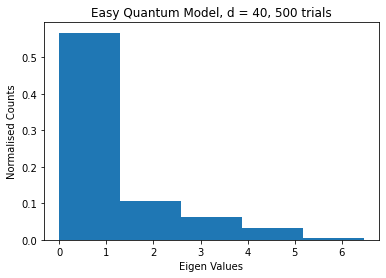

In [19]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5, density=True)
plt.title("Easy Quantum Model, d = 40, 500 trials")
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("EasyQuantum40500")
plt.show()

In [20]:
import pickle

In [21]:
file_name = "EasyQuantum40500.pkl"

open_file = open(file_name, "wb")
pickle.dump([dataV,fubini_matrices,eigen_vals,paramsV,eigen_values], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()

In [22]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [23]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]

In [24]:
eigvals_bw01

[-4.1921732276610835e-16,
 -5.893869365444993e-17,
 2.448655735303801e-16,
 3.990307443141299e-16,
 4.0341827883169017e-16,
 4.448601334111031e-16,
 4.830493080087529e-16,
 5.420582046801629e-16,
 5.882009231984521e-16,
 6.901104657928558e-16,
 9.482779602395562e-16,
 0.006116379143580051,
 0.011865418779245181,
 0.023401015145214404,
 0.03136797047717311,
 0.048179942468543506,
 0.04997382152651436,
 0.06952022130231275,
 0.08360691324589199,
 0.09732958055892096,
 0.1259527960990398,
 0.15846954723342527,
 0.1929438730289963,
 0.228876674021251,
 0.2726786359396653,
 0.6415718367533327,
 0.8215154375670605,
 0.9710984327256272,
 -6.545732924712339e-16,
 -3.3917100459942054e-16,
 -3.3786056451433633e-16,
 -2.6669983056943886e-16,
 -2.579742001627323e-17,
 -9.711920755355605e-18,
 6.034557067829341e-17,
 7.699800770779191e-17,
 8.928211765898595e-17,
 2.335592694683687e-16,
 3.488283679753799e-16,
 0.02974904337435764,
 0.03574167440722381,
 0.05884034735005636,
 0.0868682353134585,
 0